In [105]:
from matplotlib import pyplot as plt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
from skimage.color import rgb2gray
import cv2
import cv2.cv as cv
from os.path import join
from skimage.filters import roberts, sobel, scharr, prewitt
%matplotlib inline
import numpy as np
import scipy as sp

In [106]:
# sp.ndimage.filters.laplace()

In [107]:
orange_hsv_lows = (2.9998, 110.9023, 115.2693)
orange_hsv_highs = (12.5524, 245.7831, 254.9564)

green_hsv_lows = (35.8691, 107.8961, 115.0839)
green_hsv_highs = (57.0588, 224.1300, 254.9658)

# im_bgr = cv2.imread(join('sample', '1456792623.png'))
im_bgr = cv2.imread(join('dataset/floor3', '1456441317.png'))
im_hsv = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2HSV)

In [108]:
im_bgr_55 = cv2.GaussianBlur(im_bgr,(5,5),0)

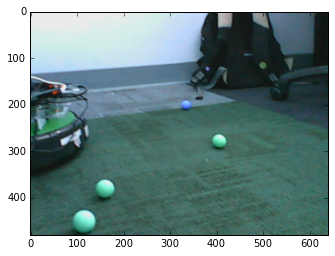

In [109]:
plt.imshow(im_bgr_55)
plt.show()

In [110]:
im_gray = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2GRAY)
circles = cv2.HoughCircles(im_gray,cv.CV_HOUGH_GRADIENT,1,20,
                           param1=50,param2=30,minRadius=0,maxRadius=0)

In [111]:
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(im_bgr,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(im_bgr,(i[0],i[1]),2,(0,0,255),3)

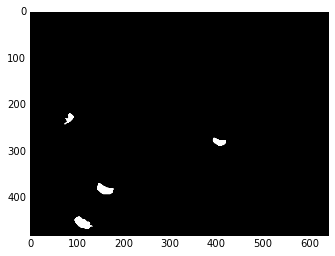

In [112]:
green_hsv_lows = (35.8691, 110.8961, 160.0839)
green_hsv_highs = (57.0588, 224.1300, 254.9658)

## hsv_to_center_radius
surpress_when_large=True
supress_sv=True

# mask by threshold
im_mask = cv2.inRange(im_hsv, green_hsv_lows, green_hsv_highs)
im_mask = cv2.medianBlur(im_mask, 5)
im_mask1 = im_mask.copy()
plt.imshow(im_mask1, cmap='gray')
plt.show()
# erode
im_mask = cv2.erode(im_mask, None, iterations=2)
im_mask2 = im_mask.copy()
# dilate
im_mask = cv2.dilate(im_mask, None, iterations=2)
im_mask3 = im_mask.copy()

# find contours
contours = cv2.findContours(im_mask.copy(), cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)[-2]

# get centers and radiuses
centers = []
radiuses = []

for countour in contours:
    center, radius = cv2.minEnclosingCircle(countour)
    centers.append((int(center[0]), int(center[1])))  # a tuple
    radiuses.append(int(radius))  # an int

if surpress_when_large and len(radiuses) > 0:
    max_radius = max(radiuses)
    if max_radius * 2 > im_hsv.shape[0] * 0.4:
        centers_new = []
        radiuses_new = []
        for center, radius in zip(centers, radiuses):
            if radius * 2 > im_hsv.shape[0] * 0.05:
                centers_new.append(center)
                radiuses_new.append(radius)
        centers = centers_new
        radiuses = radiuses_new

In [113]:
if supress_sv:
    # elimate v that are smaller than global mean
    v_mean = np.mean(im_hsv[:,:,2])
    centers_new = []
    radiuses_new = []
    im_mean_mask = np.zeros(im_hsv.shape[:2]).astype(np.uint8)
    for center, radius in zip(centers, radiuses):
        # reset
        im_mean_mask[:] = 0
        # mask to "1" at the ball location
        cv2.circle(im_mean_mask, center, radius, color=1, thickness=-1)
        # area
        area = np.sum(im_mean_mask)
        # get mean, element wise product
        im_mean_mask = im_mean_mask * im_hsv[:,:,2]
        v_mean_local = np.sum(im_mean_mask) / float(area)
        if v_mean_local >= v_mean:
            centers_new.append(center)
            radiuses_new.append(radius)
    centers = centers_new
    radiuses = radiuses_new

In [114]:
im_sum_mask = np.zeros(im_hsv.shape[:2]).astype(np.uint8)


In [115]:
np.max(im_sum_mask)

0

In [116]:
# # image = data.hubble_deep_field()[0:500, 0:500]
# image = cv2.imread(join('dataset/floor1', '1456268992.png'))
# # image = cv2.imread(join('dataset/floor3', '1456441317.png'))
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image_gray = rgb2gray(image)

In [117]:
image = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
image_gray = rgb2gray(im_hsv[:,:,1] / 255.)

In [118]:
image_gray = im_hsv[:,:,1] / 255.

In [119]:
# im_hsv[:,:,0] / 179.

In [120]:
# plt.imshow(im_hsv[:,:,3] / 179., cmap='gray')
# plt.show()

In [121]:
blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)
# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

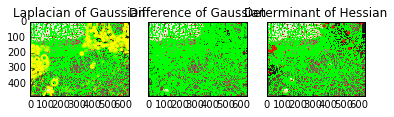

In [122]:
blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)


fig,axes = plt.subplots(1, 3, sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})
axes = axes.ravel()
for blobs, color, title in sequence:
    ax = axes[0]
    axes = axes[1:]
    ax.set_title(title)
    ax.imshow(image, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax.add_patch(c)

plt.show()